In [28]:
# Packages
import numpy as np
import pandas as pd

from  matplotlib import pyplot as plt
import seaborn as sns

# from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score

from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
# Print more rows and columns of pandas.DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

##### **<font color='green'>Versions of the important packages</font>**
- <font color='green'>sklearn</font>
- <font color='green'>imblearn</font>
- <font color='green'>lightgbm</font>

In [3]:
import sklearn
sklearn.__version__

'0.24.1'

In [4]:
import imblearn
imblearn.__version__

'0.8.0'

In [5]:
import lightgbm
lightgbm.__version__

'3.2.1'

In [6]:
# Change path if needed
path = r'C:\Users\user\Desktop\KUL - Mstat\Big Data Platforms and Technologies\project'
# data = training data after preprocessing, whereas data_test = test data after preprocessing
data = pd.read_csv(path + r'\ctrain.csv')
data_test = pd.read_csv(path + r'\ctest.csv')

---

### **<font color='gray'>Model building</font>**
- **<font color='gray'>Please refer to "Model building - Model pipeline" in the report</font>**

#### **<font color='blue'>Featurization - data binning and weight-of-evidence encoding</font>**

In [7]:
# Calculate weight-of-evidence, and information value
def get_information_value(data, features):
    # cross tab
    tab = pd.crosstab(data[features], data['fraud'])
    # weight of evidence
    tab['all'] = tab[['Y', 'N']].sum(axis = 1) 
    tab['share'] = tab['all'] / tab['all'].sum(axis = 0)
    tab['Y_rate'] = tab['Y'] / tab['all']
    tab['N_dist'] = tab['N'] / tab['N'].sum()
    tab['Y_dist'] = tab['Y'] / tab['Y'].sum()
    tab['WoE'] = np.log(tab['N_dist'] / tab['Y_dist'])
    tab = tab.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    # information value
    tab['IV'] = tab['WoE'] * (tab['N_dist'] - tab['Y_dist'])
    return tab[np.abs(tab['IV']) > 0.01].index.values # threshold 0.01

In [8]:
# Extract factor levels from categorical features according to their information values
# third_party_3_postal_code is omitted because no fraudulent cases in the trainig data
claim_postal_code_list = get_information_value(data, 'claim_postal_code')
policy_holder_postal_code_list = get_information_value(data, 'policy_holder_postal_code')
driver_postal_code_list = get_information_value(data, 'driver_postal_code')
third_party_1_postal_code_list = get_information_value(data, 'third_party_1_postal_code')
third_party_2_postal_code_list = get_information_value(data, 'third_party_2_postal_code')
repair_postal_code_list = get_information_value(data, 'repair_postal_code')
policy_coverage_type_list = get_information_value(data, 'policy_coverage_type')

C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Bin age into equal intervals
# Thresholds are observed from the training data
def handle_age(value):
    if pd.isna(value):
        return 'unknown'
    else:
        if value <= 20:
            return '<=20'
        elif value <= 40:
            return '<=40'
        elif value <= 60:
            return '<=60'
        elif value <= 80:
            return '<=80'
        else:
            return '>80'

# As policy_coverage_1000 has > 50% missing values in the training data
# We discretize it into equal intervals
# The thresholds are hardcoded and calculated from the training data
def handle_policy_coverage(value):
    if pd.isna(value):
        return 'unknown'
    else:
        if value <= 20:
            return '<=20'
        elif value <= 40:
            return '<=40'
        elif value <= 60:
            return '<=60'
        elif value <= 80:
            return '<=80'
        else:
            return '>80'

# Given information values as grouping_list, bin factor levels according to the list
# For missing values, keep it as 'unknown'
# For factor levels which have information value less than the prespecified threshold, group them into 'other'
def handle_categorical_grouping(value, grouping_list):
        if value == 'unknown':
            return value
        elif value in grouping_list:
            return str(value)
        else:
            return 'other'

# Transform the features using the functions defined as above
def transform(x_dataset):
        x_dataset['driver_age'] = x_dataset['driver_age'].apply(lambda x: handle_age(x))
        x_dataset['policy_holder_age'] = x_dataset['policy_holder_age'].apply(lambda x: handle_age(x))
        x_dataset['repair_age'] = x_dataset['repair_age'].apply(lambda x: handle_age(x))
        x_dataset['third_party_1_age'] = x_dataset['third_party_1_age'].apply(lambda x: handle_age(x))
        x_dataset['third_party_2_age'] = x_dataset['third_party_2_age'].apply(lambda x: handle_age(x))
        x_dataset['third_party_3_age'] = x_dataset['third_party_3_age'].apply(lambda x: handle_age(x))
        x_dataset['policy_coverage_1000'] = x_dataset['policy_coverage_1000'].apply(lambda x: handle_policy_coverage(x))
        x_dataset['claim_postal_code'] = x_dataset['claim_postal_code'].apply(lambda x: handle_categorical_grouping(x, claim_postal_code_list))
        x_dataset['policy_holder_postal_code'] = x_dataset['policy_holder_postal_code'].apply(lambda x: handle_categorical_grouping(x, policy_holder_postal_code_list))
        x_dataset['driver_postal_code'] = x_dataset['driver_postal_code'].apply(lambda x: handle_categorical_grouping(x, driver_postal_code_list))
        x_dataset['third_party_1_postal_code'] = x_dataset['third_party_1_postal_code'].apply(lambda x: handle_categorical_grouping(x, third_party_1_postal_code_list))
        x_dataset['third_party_2_postal_code'] = x_dataset['third_party_2_postal_code'].apply(lambda x: handle_categorical_grouping(x, third_party_2_postal_code_list))
        x_dataset['third_party_3_postal_code'] = x_dataset['third_party_3_postal_code'].apply(lambda x: x if x == 'unknown' else 'other')
        x_dataset['repair_postal_code'] = x_dataset['repair_postal_code'].apply(lambda x: handle_categorical_grouping(x, repair_postal_code_list))
        x_dataset['policy_coverage_type'] = x_dataset['policy_coverage_type'].apply(lambda x: handle_categorical_grouping(x, policy_coverage_type_list))        
        return x_dataset.drop(['third_party_1_id_known', 'third_party_2_id_known', 'third_party_3_id_known'], axis = 1)

In [10]:
# Preprocessing: Data binning of age-related features, policy_coverage_1000 (> 50% missing data), policy_coverage_type and postal-code related features (using weight of evidence encoding)
data = transform(data)
data_test = transform(data_test)
# Sanity check: fraud, claim_amount only
set(data.columns) - set(data_test.columns)

{'claim_amount', 'fraud'}

In [11]:
# Prepare dataset for the model pipeline
X, y = pd.get_dummies(data.drop(['claim_id', 'fraud'], axis = 1), drop_first = True), data['fraud'].apply(lambda x: 1 if x == 'Y' else 0)
# Remove claim_id and target from training set, encode target into binary variable
X_test = pd.get_dummies(data_test.drop(['claim_id'], axis = 1)) # Remove claim_id from test set
cv = 5 # Grid search - split the training data into 5 folds

### **<font color='blue'>Grid search for randomforeset model</font>**

In [48]:
# Grid search function for randomforest model
def gridcv(X, y, k_neighbors, max_features, n_estimators):
    precision_weighted_score = []
    recall_weighted_score = []
    total_sum = np.array([])
    predicted_prob = np.array([])
    true_lbl = np.array([])
    skf = StratifiedKFold(n_splits = cv, shuffle = True)
    # Go over k-folds
    for train_index, test_index in skf.split(X, y):
        w, Xc = X[['claim_amount']], X.drop(['claim_amount'], axis = 1)
        # train-test split
        w_train, Xc_train, y_train = w.iloc[train_index], Xc.iloc[train_index], y[train_index]
        w_test, Xc_test, y_test = w.iloc[test_index], Xc.iloc[test_index], y[test_index]
        # pipeline
        pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median', add_indicator = True)), 
                         ('upsampling', SMOTE(random_state = 99, k_neighbors = k_neighbors)),
                         ('classifier',  RandomForestClassifier(random_state = 99, max_features = max_features, 
                                                                n_estimators = n_estimators, 
                                                                n_jobs = -1))])
        pipe.fit(Xc_train, y_train)
        # A calibration classifier, default is logistic, use 3-fold cross validation (To have reasonable training time)
        calibrated_pipe = CalibratedClassifierCV(base_estimator = pipe, cv = 3, n_jobs = -1)
        calibrated_pipe.fit(Xc_train, y_train)
        # Prediction based on features from test set
        y_pred = calibrated_pipe.predict_proba(Xc_test)[:, 1]
        y_predt = calibrated_pipe.predict(Xc_test)
        # Scoring function calculation
        # Precision and recall for each fold and take the average, like as usual cross validation
        precision_weighted_score.append(precision_score(y_test, y_predt, sample_weight = w_test.to_numpy().ravel()))
        recall_weighted_score.append(recall_score(y_test, y_predt, sample_weight = w_test.to_numpy().ravel()))
        # Concatenate estimated probabilities from the model
        total_sum = np.concatenate((w_test.to_numpy().ravel(), total_sum))
        predicted_prob = np.concatenate((y_pred, predicted_prob))
        true_lbl = np.concatenate((y_test, true_lbl))
        
    max_ind = np.argsort(-predicted_prob)[:100] # Sorted by estimated probabilities in descending order
     # sum_top100 = True positive cases among top 100 cases, and sum their claim amounts
    return [{'k_neighbors': k_neighbors, 'max_features': max_features, 'n_estimators': n_estimators, 
            'cv_precision_score': np.mean(precision_weighted_score), 'cv_recall_score': np.mean(recall_weighted_score),
           'sum_top100': np.dot(true_lbl[max_ind], total_sum[max_ind])}]
        
# hyperparameters grid search
smote_knn_param = [3, 5, 7] # k_neighbors for SMOTE
rf_param_nfeatures = [10, 30, 50, 70] # max_featurse for randomforest
i = 1
ttl = len(smote_knn_param) * len(rf_param_nfeatures)

# It should take 4 hours to run for 8-core computer
data_results_rf = pd.DataFrame()
for _ in range(0, 5):
    for k in smote_knn_param:
        for m in rf_param_nfeatures:
            results = gridcv(X, y, k, m, 200)
            data_results_rf = data_results_rf.append(results)
            print(i/ttl)
            i += 1

0.08333333333333333
0.16666666666666666
0.25
0.3333333333333333
0.4166666666666667
0.5
0.5833333333333334
0.6666666666666666
0.75
0.8333333333333334
0.9166666666666666
1.0
1.0833333333333333
1.1666666666666667
1.25
1.3333333333333333
1.4166666666666667
1.5
1.5833333333333333
1.6666666666666667
1.75
1.8333333333333333
1.9166666666666667
2.0
2.0833333333333335
2.1666666666666665
2.25
2.3333333333333335
2.4166666666666665
2.5
2.5833333333333335
2.6666666666666665
2.75
2.8333333333333335
2.9166666666666665
3.0
3.0833333333333335
3.1666666666666665
3.25
3.3333333333333335
3.4166666666666665
3.5
3.5833333333333335
3.6666666666666665
3.75
3.8333333333333335
3.9166666666666665
4.0
4.083333333333333
4.166666666666667
4.25
4.333333333333333
4.416666666666667
4.5
4.583333333333333
4.666666666666667
4.75
4.833333333333333
4.916666666666667
5.0


In [55]:
# Save the results
data_results_rf.to_csv('rf_results.csv')

---

### **<font color='blue'>Grid search for LightGBM model</font>**

In [42]:
# Grid search function for LightGBM model
def gridcv_gb(X, y, k, nl, lr):
    precision_weighted_score = []
    recall_weighted_score = []
    total_sum = np.array([])
    predicted_prob = np.array([])
    true_lbl = np.array([])
    skf = StratifiedKFold(n_splits = cv, shuffle = True)
    # Go over k-folds
    for train_index, test_index in skf.split(X, y):
        w, Xc = X[['claim_amount']], X.drop(['claim_amount'], axis = 1)
        # train-test split
        w_train, Xc_train, y_train = w.iloc[train_index], Xc.iloc[train_index], y[train_index]
        w_test, Xc_test, y_test = w.iloc[test_index], Xc.iloc[test_index], y[test_index]
        # pipeline
        pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median', add_indicator = True)), 
                         ('upsampling', SMOTE(random_state = 99, k_neighbors = k)),
                         ('classifier',  LGBMClassifier(random_state = 99, num_leaves = nl, learning_rate = lr, max_depth = 7))])
        pipe.fit(Xc_train, y_train)
        # A calibration classifier, default is logistic, use 3-fold cross validation (To have reasonable training time)
        calibrated_pipe = CalibratedClassifierCV(base_estimator = pipe, cv = 3, n_jobs = -1)
        calibrated_pipe.fit(Xc_train, y_train) # Train on the same training set. 
        # Prediction based on features from test set
        y_pred = calibrated_pipe.predict_proba(Xc_test)[:, 1]
        y_predt = calibrated_pipe.predict(Xc_test)
        # Scoring function calculation
        # Precision and recall for each fold and take the average, like as usual cross validation
        precision_weighted_score.append(precision_score(y_test, y_predt, sample_weight = w_test.to_numpy().ravel()))
        recall_weighted_score.append(recall_score(y_test, y_predt, sample_weight = w_test.to_numpy().ravel()))
        # Concatenate estimated probabilities from the model
        total_sum = np.concatenate((w_test.to_numpy().ravel(), total_sum))
        predicted_prob = np.concatenate((y_pred, predicted_prob))
        true_lbl = np.concatenate((y_test, true_lbl))
        
    max_ind = np.argsort(-predicted_prob)[:100] # Sorted by estimated probabilities in descending order
    # sum_top100 = True positive cases among top 100 cases, and sum their claim amounts
    return [{'k_neighbors': k, 'number of leaves': nl, 'learning rate': lr, 
            'cv_precision_score': np.mean(precision_weighted_score), 'cv_recall_score': np.mean(recall_weighted_score),
           'sum_top100': np.dot(true_lbl[max_ind], total_sum[max_ind])}]
        
# hyperparameters grid search
num_leaves = [10, 20, 30] # Number of leaves for each weak learner in LightGBM
learning_rate = [0.05, 0.1, 0.2] # 
knn = [3, 5, 7]
i = 1
ttl = len(num_leaves) * len(learning_rate) * len(knn) * 5

# It should take less than 2 hours to run for 8-core computer
data_results = pd.DataFrame()
for _ in range(0, 5):
    for nl in num_leaves:
        for lr in learning_rate:
            for k in knn:
                results = gridcv_gb(X, y, k, nl, lr)
                data_results = data_results.append(results)
                print(round(i/ttl*100, 4))
                i += 1

0.7407
1.4815
2.2222
2.963
3.7037
4.4444
5.1852
5.9259
6.6667
7.4074
8.1481
8.8889
9.6296
10.3704
11.1111
11.8519
12.5926
13.3333
14.0741
14.8148
15.5556
16.2963
17.037
17.7778
18.5185
19.2593
20.0
20.7407
21.4815
22.2222
22.963
23.7037
24.4444
25.1852
25.9259
26.6667
27.4074
28.1481
28.8889
29.6296
30.3704
31.1111
31.8519
32.5926
33.3333
34.0741
34.8148
35.5556
36.2963
37.037
37.7778
38.5185
39.2593
40.0
40.7407
41.4815
42.2222
42.963
43.7037
44.4444
45.1852
45.9259
46.6667
47.4074
48.1481
48.8889
49.6296
50.3704
51.1111
51.8519
52.5926
53.3333
54.0741
54.8148
55.5556
56.2963
57.037
57.7778
58.5185
59.2593
60.0
60.7407
61.4815
62.2222
62.963
63.7037
64.4444
65.1852
65.9259
66.6667
67.4074
68.1481
68.8889
69.6296
70.3704
71.1111
71.8519
72.5926
73.3333
74.0741
74.8148
75.5556
76.2963
77.037
77.7778
78.5185
79.2593
80.0
80.7407
81.4815
82.2222
82.963
83.7037
84.4444
85.1852
85.9259
86.6667
87.4074
88.1481
88.8889
89.6296
90.3704
91.1111
91.8519
92.5926
93.3333
94.0741
94.8148
95.5556
96

In [57]:
# Save the results
data_results.to_csv('lightbgm_gridsearch_results.csv')

---

### **<font color='gray'>Prediction</font>**

In [13]:
# Remove 'claim_amount' from training data (in hyperparameter grid search, it is removed in the grid serach function)
X_train = X.drop(['claim_amount'], axis = 1)
# Align the columns of test set with training set. In case any missing columns, fill them with 0
X_test = X_test.reindex(columns = X_train.columns, fill_value = 0)

#### **<font color='blue'>Random forest</font>**

In [132]:
# Pipeline for the chosen model
pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median', add_indicator = True)), 
                ('upsampling', SMOTE(random_state = 99, k_neighbors = 3)),
                ('classifier',  RandomForestClassifier(random_state = 99, max_features = 30, 
                                                        n_estimators = 500, 
                                                        n_jobs = -1))])
pipe.fit(X_train, y)
calibrated_pipe = CalibratedClassifierCV(base_estimator = pipe, cv = 3, n_jobs = -1)
calibrated_pipe.fit(X_train, y)

Pipeline(steps=[('imputer',
                 SimpleImputer(add_indicator=True, strategy='median')),
                ('upsampling', SMOTE(k_neighbors=3, random_state=99)),
                ('classifier',
                 RandomForestClassifier(max_features=30, n_estimators=500,
                                        n_jobs=-1, random_state=99))])

In [145]:
# Make prediction
y_pred = calibrated_pipe.predict_proba(X_test)

In [146]:
# Dataframe which contains the results
pred = pd.DataFrame()
pred['ID'] = data_test['claim_id']
pred['PROB'] = y_pred[:, 1]

In [148]:
# Export data
pred.to_csv(path + r'\results_randomforest_v2.csv', index = False)

---

#### **<font color='blue'>Light GBM</font>**

In [14]:
# Pipeline for the chosen model
pipe2 = Pipeline([('imputer', SimpleImputer(strategy = 'median', add_indicator = True)), 
                ('upsampling', SMOTE(random_state = 99, k_neighbors = 7)),
                ('classifier',   LGBMClassifier(random_state = 99, num_leaves = 20, learning_rate = 0.1,
                                               max_depth = 7))])
pipe2.fit(X_train, y)
calibrated_pipe2 = CalibratedClassifierCV(base_estimator = pipe2, cv = 3, n_jobs = -1)
calibrated_pipe2.fit(X_train, y)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('imputer',
                                                       SimpleImputer(add_indicator=True,
                                                                     strategy='median')),
                                                      ('upsampling',
                                                       SMOTE(k_neighbors=7,
                                                             random_state=99)),
                                                      ('classifier',
                                                       LGBMClassifier(max_depth=7,
                                                                      num_leaves=20,
                                                                      random_state=99))]),
                       cv=3, n_jobs=-1)

In [110]:
# Make prediction
y_pred = calibrated_pipe2.predict_proba(X_test)

In [106]:
# Dataframe which contains the results
pred = pd.DataFrame()
pred['ID'] = data_test['claim_id']
pred['PROB'] = y_pred[:, 1]

In [115]:
# Export data
pred.to_csv(path + r'\results_lightgbm_v2.csv', index = False)

---

### **<font color='gray'>Interpretable machine learning</font>**
- **<font color='gray'>Please refer to "Interpretable machine learning" in the report</font>**
- **<font color='gray'>It is for the chosen model - LightGBM</font>**

In [17]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

In [193]:
# Import hidden.csv 
data_hidden = pd.read_csv(path + r'/hidden.csv')
# Align with the ordering of data_test by claim_id
data_hidden = data_test.merge(data_hidden, how = 'left', on = 'claim_id')[['claim_id', 'fraud', 'claim_amount']]

In [20]:
y_test = pd.DataFrame()
y_test['fraud'] = data_hidden['fraud'].apply(lambda x: 1 if x == 'Y' else 0)
y_test['claim_amount'] = data_hidden['claim_amount'].copy()

**<font color='blue'>Permutation feature importance</font>**

In [73]:
# Permutation importance on training data - Accuracy
permutation_importance = PermutationImportance(calibrated_pipe2, random_state = 99)
permutation_importance.fit(X_train, y)

PermutationImportance(estimator=CalibratedClassifierCV(base_estimator=Pipeline(steps=[('imputer',
                                                                                       SimpleImputer(add_indicator=True,
                                                                                                     strategy='median')),
                                                                                      ('upsampling',
                                                                                       SMOTE(k_neighbors=7,
                                                                                             random_state=99)),
                                                                                      ('classifier',
                                                                                       LGBMClassifier(max_depth=7,
                                                                                                      num_leaves=20,
     

<font color='blue'>Default scoring function in eli5: mean accuracy</font>

In [75]:
eli5.show_weights(permutation_importance, feature_names = X_train.columns.values)

Weight,Feature
0.0012 ± 0.0001,driver_expert_id_known
0.0010 ± 0.0002,claim_num_vehicles
0.0009 ± 0.0001,claim_cause_traffic accident
0.0005 ± 0.0000,claim_cause_theft
0.0005 ± 0.0001,repair_postal_code_other
0.0002 ± 0.0001,third_party_1_vehicle_id_known
0.0001 ± 0.0000,policy_holder_postal_code_other
0.0001 ± 0.0001,third_party_1_postal_code_other
0.0001 ± 0.0001,third_party_1_vehicle_type_car
0.0001 ± 0.0001,policy_premium_100


In [140]:
permutation_importance.fit(X_test, y_test)

PermutationImportance(estimator=CalibratedClassifierCV(base_estimator=Pipeline(steps=[('imputer',
                                                                                       SimpleImputer(add_indicator=True,
                                                                                                     strategy='median')),
                                                                                      ('upsampling',
                                                                                       SMOTE(k_neighbors=7,
                                                                                             random_state=99)),
                                                                                      ('classifier',
                                                                                       LGBMClassifier(max_depth=7,
                                                                                                      num_leaves=20,
     

In [141]:
eli5.show_weights(permutation_importance, feature_names = X_test.columns.values)

Weight,Feature
0.0011 ± 0.0003,claim_num_vehicles
0.0009 ± 0.0002,claim_cause_traffic accident
0.0009 ± 0.0002,driver_expert_id_known
0.0006 ± 0.0002,repair_postal_code_other
0.0004 ± 0.0000,claim_cause_theft
0.0003 ± 0.0001,claim_cause_other
0.0002 ± 0.0001,policy_holder_expert_id_known
0.0002 ± 0.0002,third_party_1_vehicle_type_car
0.0002 ± 0.0001,third_party_1_postal_code_other
0.0001 ± 0.0001,third_party_1_vehicle_id_known


---

In [187]:
# Permutation importance on training data
def sum_top100(X, y):
    y_pred = calibrated_pipe2.predict_proba(X)[:, 1]
    claim_amount, fraud = y['claim_amount'].to_numpy().ravel(), y['fraud'].to_numpy().ravel()
    max_ind = np.argsort(-y_pred)[:100]
    claim_ttl = np.dot(claim_amount[max_ind], fraud[max_ind])
    return claim_ttl

In [188]:
y_temp = data[['claim_amount']].copy()
y_temp['fraud'] = data['fraud'].apply(lambda x: 1 if x == 'Y' else 0)

In [189]:
base_score, score_decreases = get_score_importances(sum_top100, X_train.to_numpy(), y_temp)
print('Done')

Done


In [268]:
# Summarize permutation importance
df_pimp = pd.DataFrame()
df_pimp['mean_decrease'] = np.mean(score_decreases, axis = 0)
df_pimp['features'] = X_train.columns

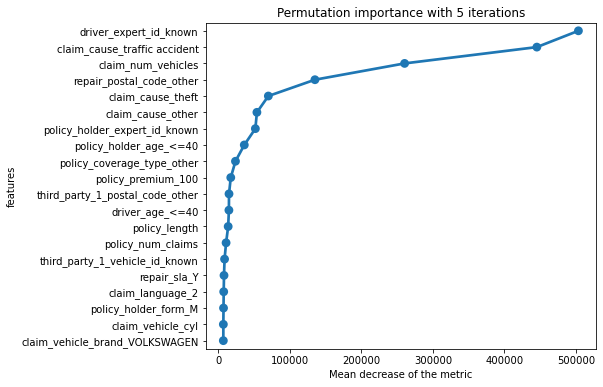

In [269]:
ax = sns.pointplot(x = 'mean_decrease', y = 'features', 
              data = df_pimp.sort_values(by = 'mean_decrease', ascending = False).head(20))
ax.set_title('Permutation importance with 5 iterations')
ax.set_xlabel('Mean decrease of the metric')
fig = ax.get_figure()
fig.set_size_inches(7, 6)
fig.savefig('permutation_imp_train.png', bbox_inches = 'tight', dpi = 300)

---

In [258]:
base_score_test, score_decreases_test = get_score_importances(sum_top100, X_test.to_numpy(), y_test)
print('Done')

Done


In [270]:
# Summarize permutation importance
df_pimp = pd.DataFrame()
df_pimp['mean_decrease'] = np.mean(score_decreases_test, axis = 0)
df_pimp['features'] = X_test.columns

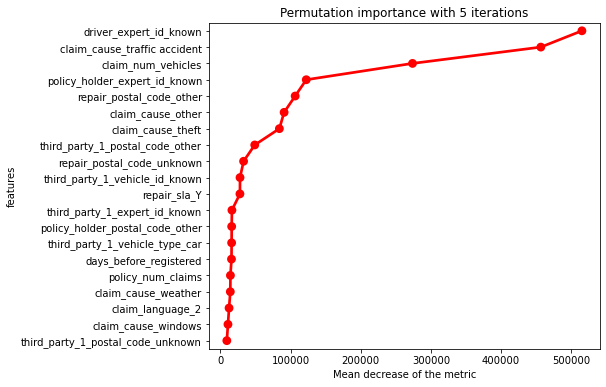

In [272]:
ax = sns.pointplot(x = 'mean_decrease', y = 'features', color = 'red',
              data = df_pimp.sort_values(by = 'mean_decrease', ascending = False).head(20))
ax.set_title('Permutation importance with 5 iterations')
ax.set_xlabel('Mean decrease of the metric')
fig = ax.get_figure()
fig.set_size_inches(7, 6)
fig.savefig('permutation_imp_test.png', bbox_inches = 'tight', dpi = 300)

In [21]:
corr_mat = X_train.corr('spearman')

In [22]:
# Spearman correlation & Data quality issues
corr_mat.unstack()[(np.abs(corr_mat.unstack()) > 0.9) & (np.abs(corr_mat.unstack()) < 1)]

claim_num_third_parties             third_party_1_country_unknown        -0.920892
                                    third_party_1_form_unknown           -0.920892
                                    third_party_1_injured_unknown        -0.920892
repair_id_known                     repair_postal_code_other              0.956456
                                    repair_postal_code_unknown           -0.999201
third_party_1_vehicle_id_known      third_party_1_vehicle_type_car        0.929388
third_party_2_vehicle_id_known      third_party_2_vehicle_type_car        0.952538
                                    third_party_2_vehicle_type_unknown   -0.905023
third_party_3_vehicle_id_known      third_party_3_vehicle_type_car        0.973320
                                    third_party_3_vehicle_type_unknown   -0.904501
driver_age_>80                      policy_holder_age_>80                 0.918137
driver_postal_code_3631             policy_holder_postal_code_3631        0.935406
driv

---

---

**<font color='blue'>Partial dependence plot</font>**

In [23]:
from sklearn.inspection import plot_partial_dependence

<font color='blue'> Partial dependence plot for claim_num_vehicles</font>

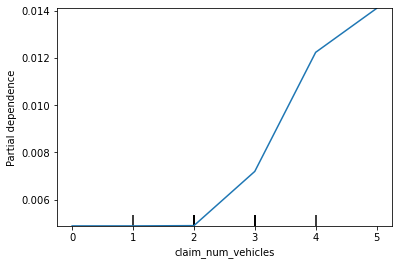

In [49]:
plot_partial_dependence(calibrated_pipe2, X_train, ['claim_num_vehicles'])
plt.savefig('pdp_claim_num_vehicles.png')

In [41]:
actual_dist = pd.crosstab(data['fraud'], data['claim_num_vehicles'], normalize = 'columns').iloc[1, :]

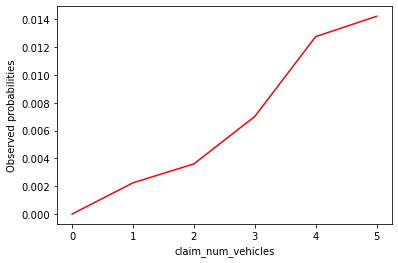

In [47]:
plt.plot(actual_dist, 'r-')
plt.xlabel('claim_num_vehicles')
plt.ylabel('Observed probabilities')
plt.savefig('observed_claim_num_vehicles.png')

<font color='blue'> Partial dependence plot for policy_premium_100</font>

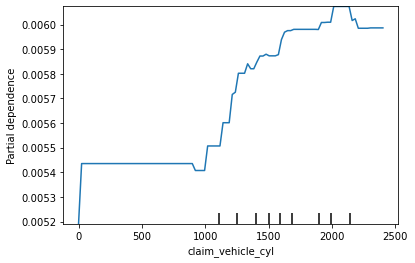

In [67]:
plot_partial_dependence(calibrated_pipe2, X_train.dropna(subset = ['claim_vehicle_cyl']), ['claim_vehicle_cyl'])
plt.savefig('pdp_claim_vehicle_cyl.png')

In [109]:
actual_dist = pd.crosstab(data['fraud'], pd.cut(data['claim_vehicle_cyl'], bins = 15), normalize = 'columns').iloc[1, :-3]

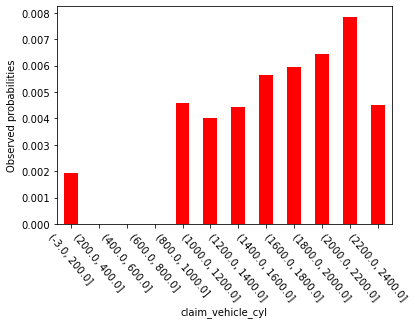

In [110]:
actual_dist.plot.bar(color = 'red', rot = -50)
plt.xlabel('claim_vehicle_cyl')
plt.ylabel('Observed probabilities')
plt.savefig('observed_claim_vehicle_cyl.png')

Using pdpbox

In [121]:
from pdpbox import pdp

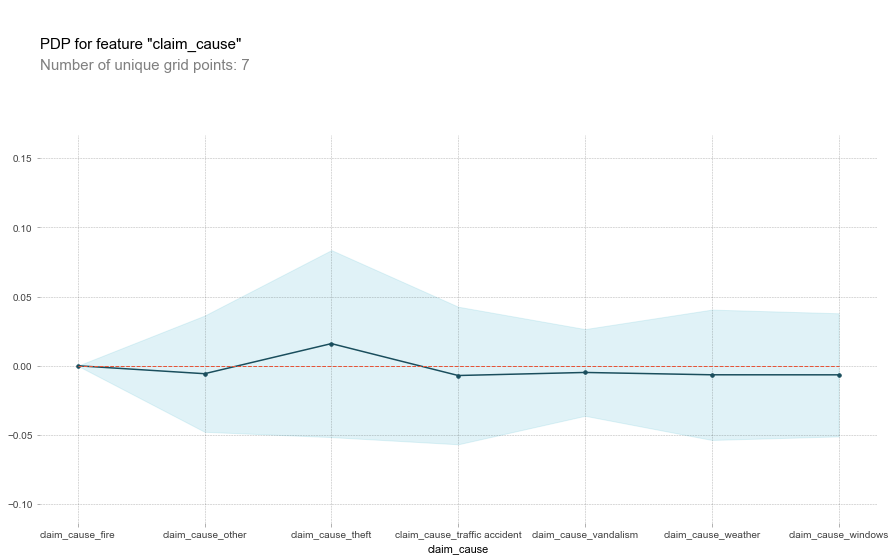

In [177]:
pdp_claim_cause = pdp.pdp_isolate(model = calibrated_pipe2, dataset = X_train, model_features = X_train.columns.values, 
                feature = ['claim_cause_fire', 'claim_cause_other', 'claim_cause_theft', 'claim_cause_traffic accident',
                           'claim_cause_vandalism', 'claim_cause_weather', 'claim_cause_windows'])
fig, axes = pdp.pdp_plot(pdp_claim_cause, 'claim_cause')

In [171]:
fig.savefig('pdp_claim_cause.png')

In [181]:
actual_dist = pd.crosstab(data['fraud'], data['claim_cause'], normalize = 'columns')
actual_dist

claim_cause,animal,fire,other,theft,traffic accident,vandalism,weather,windows
fraud,,,,,,,,
N,0.97093,0.74359,0.992468,0.840984,0.997011,1.0,0.994652,0.999614
Y,0.02907,0.25641,0.007532,0.159016,0.002989,0.0,0.005348,0.000386


In [ ]:
pdp_claim_vehicle = pdp.pdp_interact(model = calibrated_pipe2, dataset = X_train.dropna(subset = ['claim_vehicle_cyl', 'claim_vehicle_power']),
                                     model_features = X_train.columns.values, features = ['claim_vehicle_cyl', 'claim_vehicle_power'])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out = pdp_claim_vehicle, feature_names = ['claim_vehicle_cyl', 'claim_vehicle_power'], 
                                  plot_type = 'contour')

In [ ]:
fig.savefig('pdp_interaction.png')

C:\Users\user\anaconda3\lib\site-packages\pdpbox\pdp_plot_utils.py:249: UserWarning: The following kwargs were not used by contour: 'N'
  c1 = inter_ax.contourf(X, Y, pdp_mx, N=level, origin='lower', cmap=cmap, norm=norm, alpha=inter_fill_alpha)


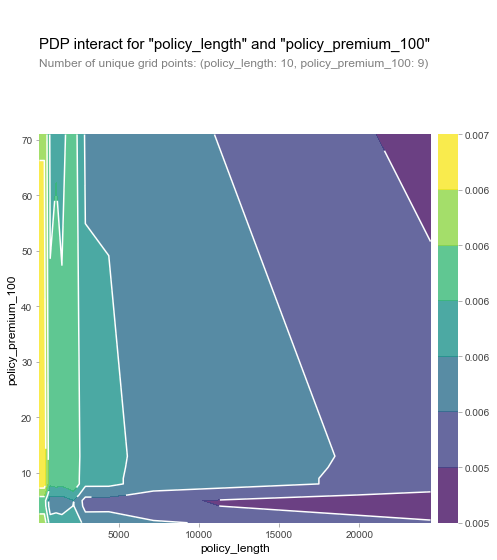

In [183]:
pdp_claim_vehicle = pdp.pdp_interact(model = calibrated_pipe2, dataset = X_train.dropna(subset = ['policy_length', 'policy_premium_100']),
                                     model_features = X_train.columns.values, features = ['policy_length', 'policy_premium_100'])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out = pdp_claim_vehicle, feature_names = ['policy_length', 'policy_premium_100'], 
                                                                                         plot_type = 'contour')

In [184]:
fig.savefig('pdp_interaction2.png')

**<font color='blue'>Individual conditional expectation plot</font>**

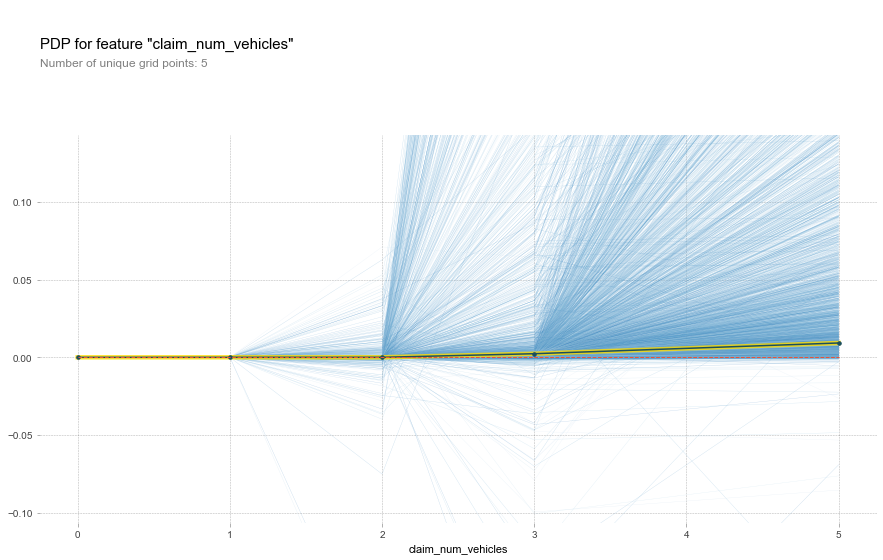

In [195]:
pdp_claim_num_vehicles = pdp.pdp_isolate(model = calibrated_pipe2, dataset = X_train, model_features = X_train.columns.values, 
                feature = 'claim_num_vehicles')
fig, axes = pdp.pdp_plot(pdp_claim_num_vehicles, 'claim_num_vehicles', plot_lines = True)

In [199]:
fig.savefig('icep_claim_num_vehicles.png')

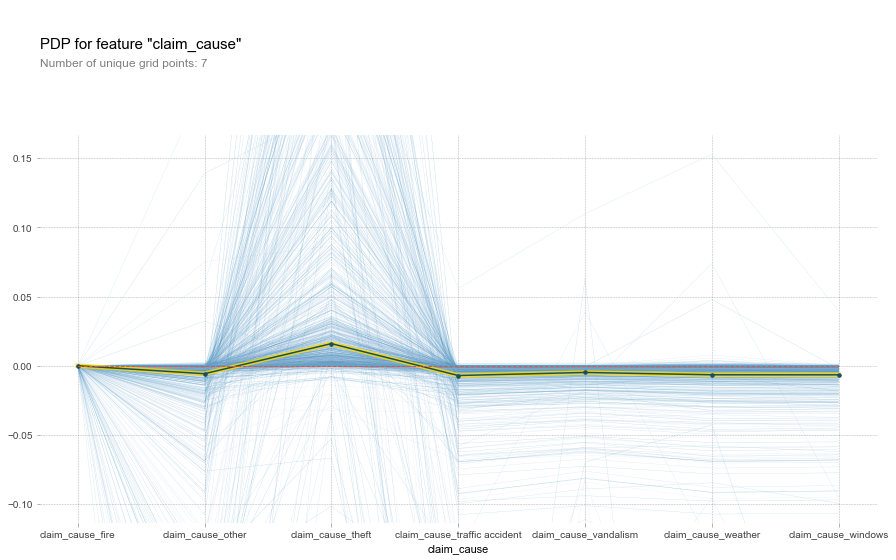

In [211]:
pdp_claim_cause = pdp.pdp_isolate(model = calibrated_pipe2, dataset = X_train, model_features = X_train.columns.values, 
                feature = ['claim_cause_fire', 'claim_cause_other', 'claim_cause_theft', 'claim_cause_traffic accident',
                           'claim_cause_vandalism', 'claim_cause_weather', 'claim_cause_windows'])
fig, axes = pdp.pdp_plot(pdp_claim_cause, 'claim_cause', plot_lines = True, frac_to_plot = 4000,
                        plot_params = {'line_cmap': 'PuBu'})

In [212]:
fig.savefig('icep_claim_cause.png')

---

In [15]:
import shap

In [16]:
X_train_transform = pipe2.steps[0][1].transform(X_train)

In [40]:
X_train_transform.shape

(55463, 330)

In [33]:
explainer = shap.Explainer(pipe2.steps[-1][1])
shap_values = explainer.shap_values(X_train_transform)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [51]:
def get_full_feature_names(pipe, data):
    colname_list = []
    ind = pipe.named_steps['imputer'].indicator_.features_
    for i, colname in enumerate(data.columns.values):
        if i in ind:
            colname_list.append(colname + '_missing_ind')
    return np.concatenate((data.columns.values, colname_list))

In [52]:
feature_name = get_full_feature_names(pipe2, X_train)

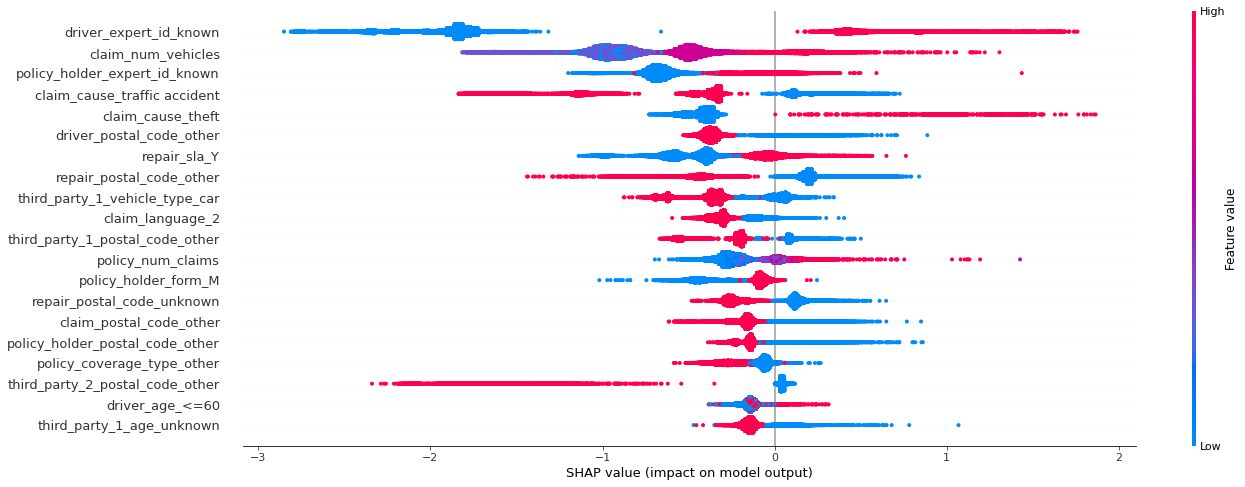

In [61]:
# Plot shapley values for all features across instances
df_shap = pd.DataFrame(X_train_transform)
df_shap.columns = feature_name
shap.summary_plot(shap_values[1], df_shap, show = False, plot_size = (20, 8))
plt.savefig('shap_summary_plt.png')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


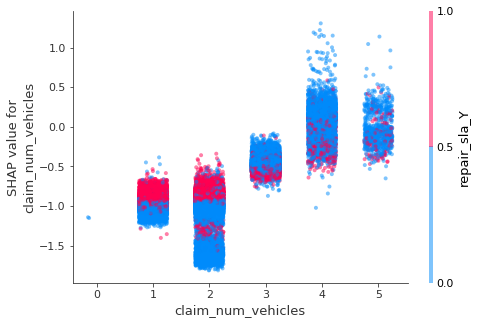

In [188]:
# Find out interesting interaction based on shapley values
shap.dependence_plot('claim_num_vehicles', shap_values[1], df_shap, show = False, x_jitter = 0.5, alpha = 0.5)
plt.savefig('shap_interaction_plt1.png')

In [87]:
top_fraud_ind = data[data['fraud'] == 'Y'].sort_values('claim_amount', ascending = False).head(5).index.values
df_top_fraud_ind = df_shap.iloc[top_fraud_ind]

In [112]:
df_top_fraud_ind

,claim_num_injured,claim_num_third_parties,claim_num_vehicles,claim_vehicle_cyl,claim_vehicle_id_known,claim_vehicle_load,claim_vehicle_power,days_before_occured,days_before_registered,driver_expert_id_known,policy_claim_length,policy_holder_expert_id_known,policy_length,policy_num_changes,policy_num_claims,policy_premium_100,repair_id_known,third_party_1_expert_id_known,third_party_1_vehicle_id_known,third_party_2_expert_id_known,third_party_2_vehicle_id_known,third_party_3_expert_id_known,third_party_3_vehicle_id_known,claim_alcohol_P,claim_alcohol_unknown,claim_cause_fire,claim_cause_other,claim_cause_theft,claim_cause_traffic accident,claim_cause_vandalism,claim_cause_weather,claim_cause_windows,claim_language_2,claim_language_unknown,claim_liable_Y,claim_police_Y,claim_postal_code_1390,claim_postal_code_2845,claim_postal_code_3400,claim_postal_code_3560,claim_postal_code_4020,claim_postal_code_4430,claim_postal_code_5030,claim_postal_code_5031,claim_postal_code_5380,claim_postal_code_5500,claim_postal_code_5560,claim_postal_code_5562,claim_postal_code_5575,claim_postal_code_5640,claim_postal_code_6001,claim_postal_code_6030,claim_postal_code_6040,claim_postal_code_6120,claim_postal_code_6560,claim_postal_code_7011,claim_postal_code_7041,claim_postal_code_7542,claim_postal_code_7700,claim_postal_code_7940,claim_postal_code_8582,claim_postal_code_8956,claim_postal_code_other,claim_time_occured_1-2,claim_time_occured_10-11,claim_time_occured_11-12,claim_time_occured_12-13,claim_time_occured_13-14,claim_time_occured_14-15,claim_time_occured_15-16,claim_time_occured_16-17,claim_time_occured_17-18,claim_time_occured_18-19,claim_time_occured_19-20,claim_time_occured_2-3,claim_time_occured_20-21,claim_time_occured_21-22,claim_time_occured_22-23,claim_time_occured_23-24,claim_time_occured_3-4,claim_time_occured_4-5,claim_time_occured_5-6,claim_time_occured_6-7,claim_time_occured_7-8,claim_time_occured_8-9,claim_time_occured_9-10,claim_time_occured_unknown,claim_vehicle_brand_AUDI,claim_vehicle_brand_BMW,claim_vehicle_brand_CHEVROLET,claim_vehicle_brand_CHRYSLER,claim_vehicle_brand_CITROEN,claim_vehicle_brand_DACIA,claim_vehicle_brand_DODGE,claim_vehicle_brand_FIAT,claim_vehicle_brand_FORD,claim_vehicle_brand_HONDA,claim_vehicle_brand_HYUNDAI,claim_vehicle_brand_IVECO,claim_vehicle_brand_JAGUAR,claim_vehicle_brand_JEEP,claim_vehicle_brand_KIA,claim_vehicle_brand_LANCIA,claim_vehicle_brand_LAND ROVER,claim_vehicle_brand_MAZDA,claim_vehicle_brand_MERCEDES,claim_vehicle_brand_MINI,claim_vehicle_brand_MITSUBISHI,claim_vehicle_brand_NISSAN,claim_vehicle_brand_OPEL,claim_vehicle_brand_PEUGEOT,claim_vehicle_brand_PORSCHE,claim_vehicle_brand_RENAULT,claim_vehicle_brand_SAAB,claim_vehicle_brand_SEAT,claim_vehicle_brand_SKODA,claim_vehicle_brand_SSANGYONG,claim_vehicle_brand_SUZUKI,claim_vehicle_brand_TOYOTA,claim_vehicle_brand_VOLKSWAGEN,claim_vehicle_brand_VOLVO,claim_vehicle_brand_unknown,claim_vehicle_fuel_type_2,claim_vehicle_fuel_type_unknown,claim_vehicle_type_unknown,claim_vehicle_type_van,driver_age_<=40,driver_age_<=60,driver_age_<=80,driver_age_>80,driver_age_unknown,driver_country_N,driver_form_M,driver_injured_Y,driver_postal_code_1390,driver_postal_code_3118,driver_postal_code_3400,driver_postal_code_3600,driver_postal_code_3631,driver_postal_code_3746,driver_postal_code_3792,driver_postal_code_3930,driver_postal_code_3940,driver_postal_code_4020,driver_postal_code_4100,driver_postal_code_4430,driver_postal_code_4540,driver_postal_code_4651,driver_postal_code_5030,driver_postal_code_5380,driver_postal_code_5530,driver_postal_code_5590,driver_postal_code_5660,driver_postal_code_6001,driver_postal_code_6030,driver_postal_code_6230,driver_postal_code_6692,driver_postal_code_6900,driver_postal_code_7020,driver_postal_code_7041,driver_postal_code_7503,driver_postal_code_7700,driver_postal_code_8020,driver_postal_code_8501,driver_postal_code_8690,driver_postal_code_9032,driver_postal_code_other,driver_postal_code_unknown,policy_cover

In [172]:
# Waterfall plot
shap2 = explainer(X_train_transform)

savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


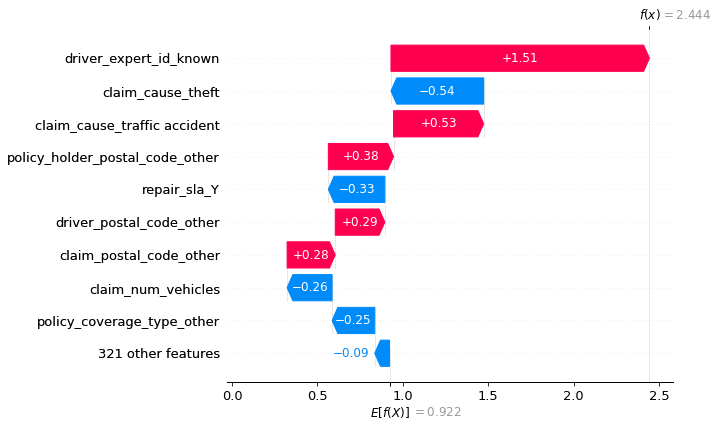

In [192]:
shap.waterfall_plot(shap.Explanation(values = shap2[443][:, 1].values, 
                 base_values = shap2[443][:, 1].base_values, 
                 feature_names = df_shap.columns), show = False,
                max_display = 10)
plt.savefig('shap_instance.png', figsize = (10, 5))

In [126]:
calibrated_pipe2.predict_proba(X_train.iloc[[443]])

array([[0.11928253, 0.88071747]])

---

### Reflection

In [239]:
from sklearn.metrics import confusion_matrix

In [219]:
pred_results = pd.DataFrame({'claim_id': data_test['claim_id'],'PROB': y_pred[:, 1]})

In [253]:
target_list = data_hidden.merge(pred_results, how = 'left', on = 'claim_id').sort_values('PROB', ascending = False)[:100]

In [259]:
# How many incorrect classification in top 100 cases?
print(target_list['fraud'].value_counts().to_latex())

\begin{tabular}{lr}
\toprule
{} &  fraud \\
\midrule
Y &     65 \\
N &     35 \\
\bottomrule
\end{tabular}



In [262]:
# Are those claim amounts for true fraudulent claims in top 100 cases really the highest?
target_list[target_list['fraud'] == 'Y'].claim_amount.sum()

742879.3300000001

In [269]:
data_hidden[data_hidden['fraud'] == 'Y'].sort_values('claim_amount', ascending = False)[:65].claim_amount.sum()

1032910.25

In [251]:
# Compare with other groups
grp99 = {'group': 99, 'private_score': 578912.07, 'private_auc': 0.86761299, 'public_score': 425532.06, 'pubilc_auc': 0.85445171}
grp21 = {'group': 21, 'private_score': 484487.41, 'private_auc': 0.85324297, 'public_score': 419268.25, 'pubilc_auc': 0.83678762}

In [252]:
print(pd.DataFrame([grp21, grp99]).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  group &  private\_score &  private\_auc &  public\_score &  pubilc\_auc \\
\midrule
0 &     21 &      484487.41 &     0.853243 &     419268.25 &    0.836788 \\
1 &     99 &      578912.07 &     0.867613 &     425532.06 &    0.854452 \\
\bottomrule
\end{tabular}



In [270]:
# How many incorrect classification in top 100 cases?
train_pred = calibrated_pipe2.predict_proba(X_train)

In [273]:
data_temp = data.copy()
data_temp['PROB'] = train_pred[:, 1]

In [274]:
target_list_train = data_temp.sort_values('PROB', ascending = False)[:100]
print(target_list_train['fraud'].value_counts().to_latex())

\begin{tabular}{lr}
\toprule
{} &  fraud \\
\midrule
Y &     89 \\
N &     11 \\
\bottomrule
\end{tabular}



In [275]:
# Are those claim amounts for true fraudulent claims in top 100 cases really the highest?
target_list_train[target_list_train['fraud'] == 'Y'].claim_amount.sum()

904364.5800000001

In [276]:
data_temp[data_temp['fraud'] == 'Y'].sort_values('claim_amount', ascending = False)[:89].claim_amount.sum()

1358414.6400000001

In [279]:
target_df = target_list.merge(data_test, how = 'left', on = 'claim_id')

In [282]:
target_df[target_df['fraud'] == 'N']

,claim_id,fraud,claim_amount,PROB,claim_alcohol,claim_cause,claim_language,claim_liable,claim_num_injured,claim_num_third_parties,claim_num_vehicles,claim_police,claim_postal_code,claim_time_occured,claim_vehicle_brand,claim_vehicle_cyl,claim_vehicle_fuel_type,claim_vehicle_id_known,claim_vehicle_load,claim_vehicle_power,claim_vehicle_type,days_before_occured,days_before_registered,driver_age,driver_country,driver_expert_id_known,driver_form,driver_injured,driver_postal_code,policy_claim_length,policy_coverage_1000,policy_coverage_type,policy_holder_age,policy_holder_country,policy_holder_expert_id_known,policy_holder_form,policy_holder_postal_code,policy_length,policy_num_changes,policy_num_claims,policy_premium_100,repair_age,repair_country,repair_form,repair_id_known,repair_postal_code,repair_sla,third_party_1_age,third_party_1_country,third_party_1_expert_id_known,third_party_1_form,third_party_1_injured,third_party_1_postal_code,third_party_1_vehicle_id_known,third_party_1_vehicle_type,third_party_2_age,third_party_2_country,third_party_2_expert_id_known,third_party_2_form,third_party_2_injured,third_party_2_postal_code,third_party_2_vehicle_id_known,third_party_2_vehicle_type,third_party_3_age,third_party_3_country,third_party_3_expert_id_known,third_party_3_form,third_party_3_injured,third_party_3_postal_code,third_party_3_vehicle_id_known,third_party_3_vehicle_type
14,69582,N,514.00,0.897359,unknown,theft,2,N,0,0,3,Y,other,unknown,BMW,1995.0,2,1,1.83,85.0,car,2857.0,0,<=60,B,1,M,N,other,218.0,<=40,#111110001,<=60,B,1,M,other,2344.0,0,4,12.0,unknown,unknown,unknown,0,unknown,N,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown
21,78164,N,9888.50,0.850798,unknown,theft,2,N,0,0,3,N,other,unknown,HYUNDAI,1991.0,2,1,2.17,100.0,car,871.0,0,<=60,B,1,M,N,other,11.0,<=40,#111110011,<=60,B,1,M,other,2922.0,6,10,13.0,unknown,unknown,unknown,0,unknown,N,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown
27,69327,N,5006.19,0.813430,unknown,theft,1,N,0,0,3,N,other,unknown,CHRYSLER,1996.0,1,1,1.92,104.0,car,5407.0,250,<=60,B,1,M,N,other,103.0,unknown,other,<=60,B,1,M,other,1461.0,1,2,4.0,unknown,B,C,1,7700,N,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown
30,84905,N,3309.85,0.754794,unknown,theft,1,N,0,0,2,Y,7700,unknown,NISSAN,1769.0,1,1,1.73,85.0,car,5171.0,5,<=80,B,1,F,N,7700,217.0,<=20,other,<=80,B,1,F,7700,3652.0,0,3,5.0,unknown,B,C,1,7700,Y,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown
41,86417,N,723.00,0.514958,unknown,traffic accident,1,N,0,0,4,Y,other,unknown,MERCEDES,2148.0,2,1,1.98,85.0,car,5538.0,12,<=40,B,1,F,N,other,94.0,unknown,#000110100,unknown,B,0,M,4540,1096.0,2,2,12.0,unknown,B,C,1,4367,N,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown
42,75131,N,10035.56,0.505241,unknown,theft,1,N,0,0,2,N,other,12-13,MERCEDES,1992.0,2,1,1.78,100.0,car,2008.0,0,<=60,B,1,F,N,other,336.0,<=40,other,<=60,B,1,F,other,1096.0,1,1,15.0,unknown,B,C,1,4020,N,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown
44,83430,N,3938.87,0.465785,unknown,theft,1,N,0,0,2,N,other,unknown,OPEL,1686.0,2,1,1.96,81.0,car,2604.0,8,<=40,B,1,M,N,other,290.0,<=20,#111110100,<=40,B,1,M,5651,2922.0,0,2,10.0,unknown,unknown,unknown,0,unknown,N,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown,unknown,unknown,0,unknown
52,85477,N,2264.94,0.369896,unknown,va

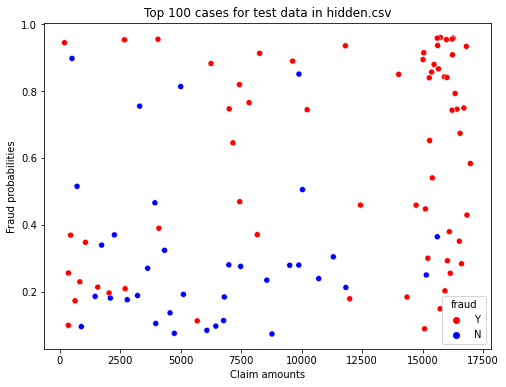

In [288]:
ax = sns.scatterplot(x = 'claim_amount', y = 'PROB', hue = 'fraud', data = target_df, palette = ['red', 'blue'])
ax.set_xlabel('Claim amounts')
ax.set_ylabel('Fraud probabilities')
ax.set_title('Top 100 cases for test data in hidden.csv')
fig = ax.get_figure()
fig.set_size_inches(8, 6)
fig.savefig('reflection1.png', bbox_inches = 'tight', dpi = 300)